# Настройка среды

In [1]:
import os
import sys
sys.path.append(os.path.abspath("../.."))

In [2]:
from belashovplot import TiledPlot
from utilities import *
from utilities.filters import Gaussian, Window
from utilities.training import train, confusion
from elements.abstracts import AbstractModulator
from elements.modulators import Lens, PhaseModulator, AmplitudeModulator
from elements.propagators import FurrierPropagation, ConvolutionalPropagation
from elements.composition import CompositeModel, HybridModel
from elements.wrappers import CudaMemoryChunker, Incoherent, FullyIncoherent
from elements.detectors import ClassificationDetectors, MatrixDetectors
from elements.simple import AdjustSize
from parameters import FigureWidthHeight, FontLibrary
from tqdm import tqdm
from math import sin, sqrt, log10, log2
import torch
import torchvision
import numpy
import timm
import pandas
from copy import deepcopy
from PIL import Image
from itertools import product

In [3]:
FontLibrary.Fonts.PlotTitle.FontSize = 16

FontLibrary.Fonts.DescriptionLeft.FontSize = 12
FontLibrary.Fonts.DescriptionLeft.FontWeight = 'bold'
FontLibrary.Fonts.DescriptionLeft.FontStyle = 'italic'

FontLibrary.Fonts.DescriptionBottom.FontSize = 10
FontLibrary.Fonts.DescriptionBottom.FontWeight = 'bold'
FontLibrary.Fonts.DescriptionBottom.FontStyle = 'italic'

FontLibrary.Fonts.DescriptionTop.FontSize = 10
FontLibrary.Fonts.DescriptionTop.FontWeight = 'bold'
FontLibrary.Fonts.DescriptionTop.FontStyle = 'italic'

FontLibrary.Fonts.ColumnDescriptionTop.FontSize = 9
FontLibrary.Fonts.ColumnDescriptionBottom.FontSize = 9
FontLibrary.Fonts.RowDescriptionLeft.FontSize = 9
FontLibrary.Fonts.RowDescriptionRight.FontSize = 9
FontLibrary.Fonts.AxisX.FontSize = 8
FontLibrary.Fonts.AxisY.FontSize = 8

FontLibrary.Fonts.GraphDescription.FontSize = 10
FontLibrary.Fonts.GraphTitle.FontSize = 10

FigureWidthHeight = (6.69291, 10.1181-1.0)

In [4]:
device = torch.device(1 if torch.cuda.is_available() else 'cpu')
print('Используемый девайс:', torch.cuda.get_device_name(device) if torch.cuda.is_available() else 'ЦП')

Используемый девайс: NVIDIA A100-SXM4-80GB


# Определение параметров модели

In [5]:
# Предпочтительные параметры
wavelength = 500.0E-9
size = wavelength*2
length = 4.0E-3
N = int(length/size)
mean_samples = 20

# Остальные параметры
initial_hole_radius = 1.5E-3
pin_hole_radius = 20.0E-6
distance = 15.0E-3
slit_width = 20.0E-6
slit_space = 100.0E-6
lines = 2
propagation = 0.5*length*numpy.sqrt((slit_space/(lines*wavelength))**2 - 1.0)
ratios_sharp = numpy.linspace(0.1, 0.6, 6)

print(f"Длинна волны:                                 {engineering(wavelength, 'м')}")
print(f"Количество вычислительных пикселей:           {N}")
print(f"Размер вычислительного пикслея:               {engineering(length/N, 'м')}")
print(f"Размер оптических элементов:                  {engineering(length, 'м')}")
print(f"Количество усреднений:                        {mean_samples}")
print(f"Диаметр болшего отверстия:                    {engineering(2*initial_hole_radius, 'м')}")
print(f"Диаметр пинхола:                              {engineering(2*pin_hole_radius, 'м')}")
print(f"Расстояние между большим отверстием и щелями: {engineering(distance, 'м')}")
print(f"Расстояние между щелями и экраном:            {engineering(propagation, 'м')}")
print(f"Расстояние между щелями:                      {engineering(slit_space, 'м')}")
print(f"Ширина щелей:                                 {engineering(slit_width, 'м')}")

Длинна волны:                                 500.0 нм
Количество вычислительных пикселей:           4000
Размер вычислительного пикслея:               1.0 мкм
Размер оптических элементов:                  4.0 мм
Количество усреднений:                        20
Диаметр болшего отверстия:                    3.0 мм
Диаметр пинхола:                              40.0 мкм
Расстояние между большим отверстием и щелями: 15.0 мм
Расстояние между щелями и экраном:            199.99 мм
Расстояние между щелями:                      100.0 мкм
Ширина щелей:                                 20.0 мкм


# Определение функций

In [6]:
def zoom_to(length_:float):
    pixels = length_ * N / length
    delta = N - pixels
    N0 = int(delta/2)
    if N0 < 0: N0 = 0
    N1 = N0 + int(pixels)
    if N1 > N: N1 = N
    return N0, N1, length_

# Инициализация модулей и начальных данных

In [7]:
# Инициализация модулей
propagator_1 = FurrierPropagation(N, length, wavelength, 1.0, 0.0, distance*ratios_sharp[0], 0.7).to(device)
propagator_2 = FurrierPropagation(N, length, wavelength, 1.0, 0.0, distance*(1.0-ratios_sharp[0]), 0.7).to(device)
propagator_3 = FurrierPropagation(N, length, wavelength, 1.0, 0.0, propagation, 0.7).to(device)
incoherent = FullyIncoherent(mean_samples)
encoder, decoder = incoherent.pair()
encoder, decoder = encoder.to(device), decoder.to(device)

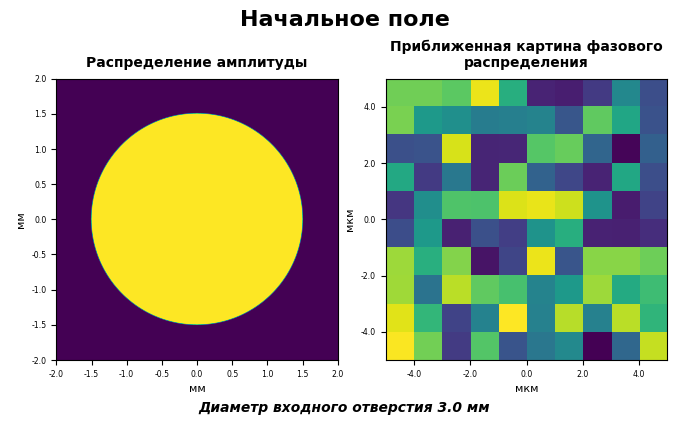

In [16]:
# Начальное поле
with torch.no_grad():
    x_mesh, y_mesh = torch.meshgrid(*[torch.linspace(-length/2,+length/2,N,device=device)]*2, indexing='ij')
    r_mesh = torch.sqrt(x_mesh**2 + y_mesh**2)
    
    initial = (r_mesh < initial_hole_radius).unsqueeze(0).unsqueeze(0).to(torch.complex64)
    initial_phased = (encoder.forward(initial)[0,0].angle()*initial[0,0].abs()).cpu()

plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = FontLibrary
plot.title("Начальное поле")
plot.description.bottom(f"Диаметр входного отверстия {engineering(2*initial_hole_radius,'м')}")

formatter, unit = engineering.separatedformatter(length, 'м')
axes = plot.axes.add(0,0)
axes.imshow(torch.abs(initial.squeeze()).cpu(), aspect='auto', extent=[-length/2,+length/2]*2)
axes.xaxis.set_major_formatter(formatter)
axes.yaxis.set_major_formatter(formatter)
plot.graph.label.x(unit)
plot.graph.label.y(unit)
plot.graph.title("Распределение амплитуды")


N0, N1, L = zoom_to(10.0E-6)
formatter, unit = engineering.separatedformatter(L, 'м')
axes = plot.axes.add(1,0)
axes.imshow(initial_phased[N0:N1,N0:N1], aspect='auto', extent=[-L/2,+L/2]*2)
axes.xaxis.set_major_formatter(formatter)
axes.yaxis.set_major_formatter(formatter)
plot.graph.label.x(unit)
plot.graph.label.y(unit)
plot.graph.title("Приближенная картина фазового распределения")

plot.show()

del initial_phased

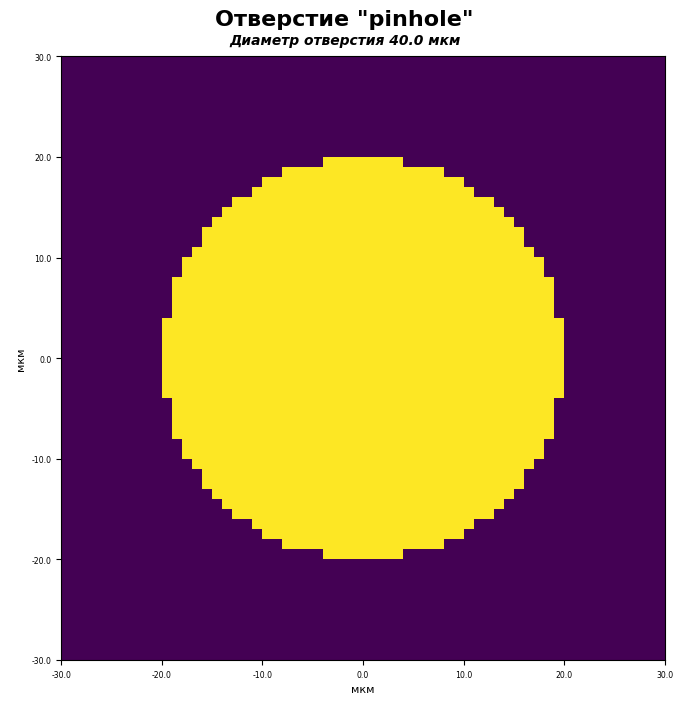

In [15]:
# Маска
with torch.no_grad():
    pinhole = (r_mesh < pin_hole_radius).to(torch.float32)

plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = FontLibrary
plot.title("Отверстие \"pinhole\"")
plot.description.top(f"Диаметр отверстия {engineering(2*pin_hole_radius,'м')}")

N0, N1, L = zoom_to(min(pin_hole_radius*3, length))
formatter, unit = engineering.separatedformatter(L, 'м')
axes = plot.axes.add(0,0)
axes.imshow(pinhole.cpu()[N0:N1,N0:N1], aspect='auto', extent=[-L/2,+L/2]*2)
axes.xaxis.set_major_formatter(formatter)
axes.yaxis.set_major_formatter(formatter)
plot.graph.label.x(unit)
plot.graph.label.y(unit)

plot.show()

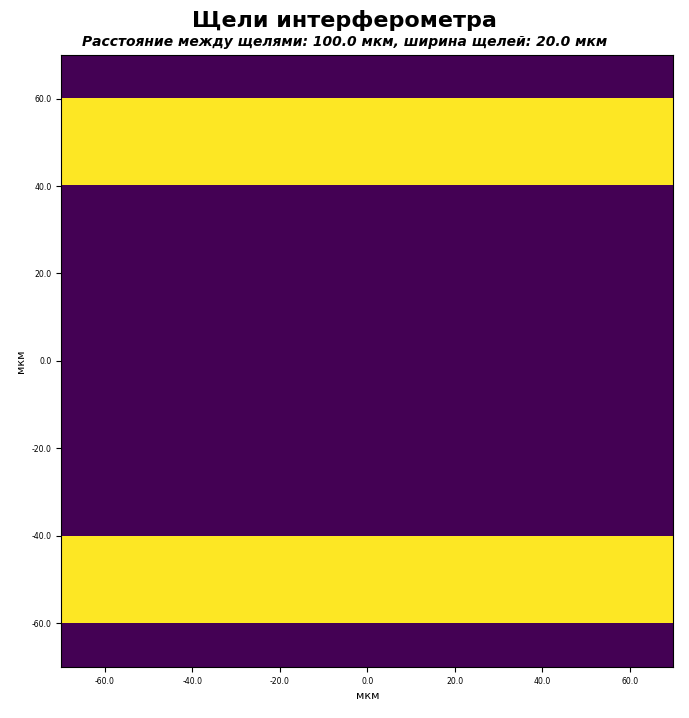

In [10]:
# Щели
with torch.no_grad():
    slits = (((x_mesh > -(slit_space+slit_width)/2)*(x_mesh < -(slit_space-slit_width)/2)) + ((x_mesh > +(slit_space-slit_width)/2)*(x_mesh < +(slit_space+slit_width)/2))).to(torch.float32)

plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = FontLibrary
plot.title("Щели интерферометра")
plot.description.top(f"Расстояние между щелями: {engineering(slit_space,'м')}, ширина щелей: {engineering(slit_width,'м')}")

N0, N1, L = zoom_to(min(slit_space+slit_width*2, length))
formatter, unit = engineering.separatedformatter(L, 'м')
axes = plot.axes.add(0,0)
axes.imshow(torch.abs(slits).squeeze().cpu()[N0:N1,N0:N1], aspect='auto', extent=[-L/2,+L/2]*2)
axes.xaxis.set_major_formatter(formatter)
axes.yaxis.set_major_formatter(formatter)
plot.graph.label.x(unit)
plot.graph.label.y(unit)

plot.show()

# Пристрелочные грубые расчёты

In [11]:
pin_hole_max, pin_hole_min = -1.0E+36, +1.0E+36
pin_hole_intensities = []
pin_hole_phases = []

slits_max, slits_min = -1.0E+36, +1.0E+36
slits_intensities = []
slits_phases = []

screen_max, screen_min = -1.0E+36, +1.0E+36
screen_intensities = []
screen_phases = []

with torch.no_grad():
    for ratio in tqdm(ratios_sharp):
        propagator_1.distance = distance * ratio
        propagator_2.distance = distance * (1.0 - ratio)

        field = encoder.forward(initial)
        filed = propagator_1.forward(field)

        pin_hole_intensities.append(decoder.forward(field).abs().cpu()[0,0])
        pin_hole_phases.append(field.angle().cpu()[0,0])
        maximum, minimum = torch.max(pin_hole_intensities[-1]), torch.min(pin_hole_intensities[-1])
        if pin_hole_max < maximum: pin_hole_max = maximum
        if pin_hole_min > minimum: pin_hole_min = minimum
        
        field = field*pinhole
        field = propagator_2.forward(field)
        
        slits_intensities.append(decoder.forward(field).abs().cpu()[0,0])
        slits_phases.append(field.angle().cpu()[0,0])
        maximum, minimum = torch.max(slits_intensities[-1]), torch.min(slits_intensities[-1])
        if slits_max < maximum: slits_max = maximum
        if slits_min > minimum: slits_min = minimum
        
        field = field*slits
        field = propagator_3.forward(field)

        screen_intensities.append(decoder.forward(field).abs().cpu()[0,0])
        screen_phases.append(field.angle().cpu()[0,0])
        maximum, minimum = torch.max(screen_intensities[-1]), torch.min(screen_intensities[-1])
        if screen_max < maximum: screen_max = maximum
        if screen_min > minimum: screen_min = minimum

del field

100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:16<00:00,  2.78s/it]


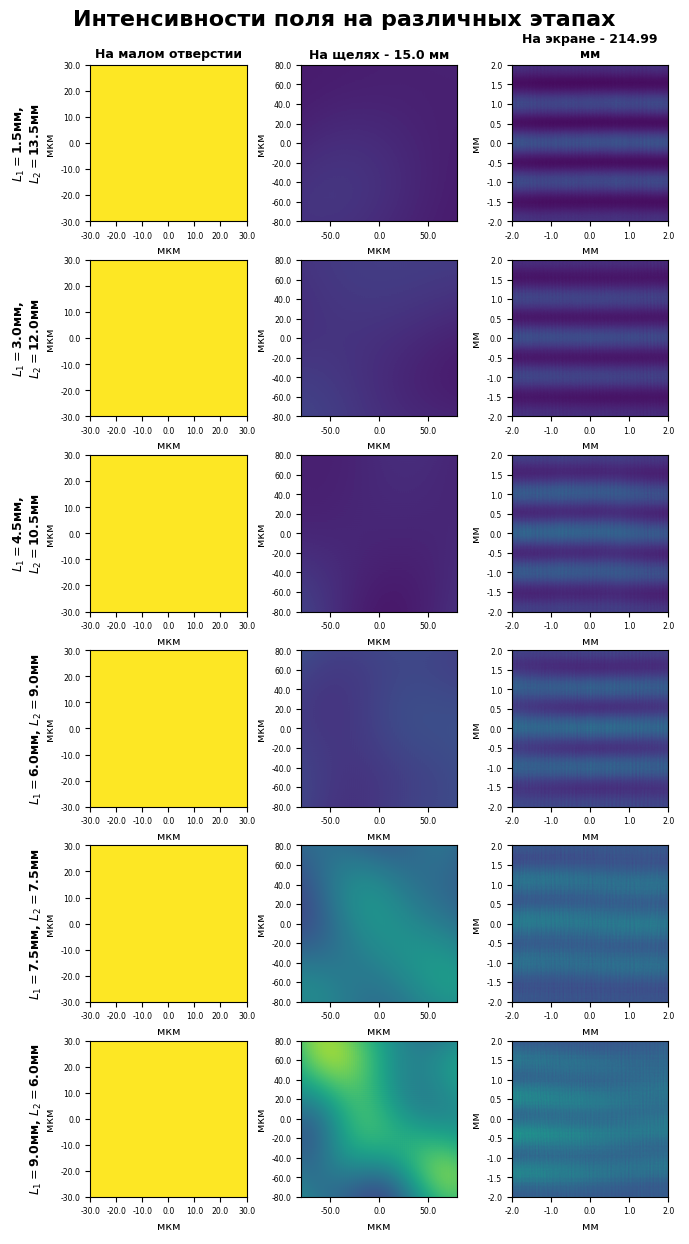

In [12]:
plot = TiledPlot(FigureWidthHeight[0])
plot.FontLibrary = FontLibrary
plot.title("Интенсивности поля на различных этапах")
plot.description.column.top("На малом отверстии", 0)
plot.description.column.top(f"На щелях - {engineering(distance,'м')}", 1)
plot.description.column.top(f"На экране - {engineering(distance+propagation,'м')}", 2)


for row, (ratio, pin_hole_image, slits_image, screen_image) in enumerate(zip(ratios_sharp, pin_hole_intensities, slits_intensities, screen_intensities)):
    distance_1 = distance * ratio
    distance_2 = distance * (1.0 - ratio)
    plot.description.row.left(f"$L_1=${engineering(distance_1,'м',1,space='')}, $L_2=${engineering(distance_2,'м',1,space='')}", row)
    for col, (image, L, maximum, minimum) in enumerate(zip(
        [pin_hole_image, slits_image, screen_image], 
        [pin_hole_radius*3, slit_space+slit_width*3, length],
        [pin_hole_max, slits_max, screen_max],
        [pin_hole_min, slits_min, screen_min],
    )):
        N0, N1, L = zoom_to(min(L, length))
        formatter, unit = engineering.separatedformatter(L, 'м')
        axes = plot.axes.add(col,row)
        axes.imshow(image[N0:N1,N0:N1], aspect='auto', extent=[-L/2,+L/2]*2, vmax=maximum, vmin=minimum)
        axes.xaxis.set_major_formatter(formatter)
        axes.yaxis.set_major_formatter(formatter)
        plot.graph.label.x(unit)
        plot.graph.label.y(unit)
        # plot.graph.description(f"$I_{{max}}=${scientific(image.max().item(),'',1,space='')}, $I_{{min}}=${scientific(image.min().item(),'',1,space='')}, $I_{{mean}}=${scientific(image.mean().item(),'',1,space='')}")
    
plot.show()

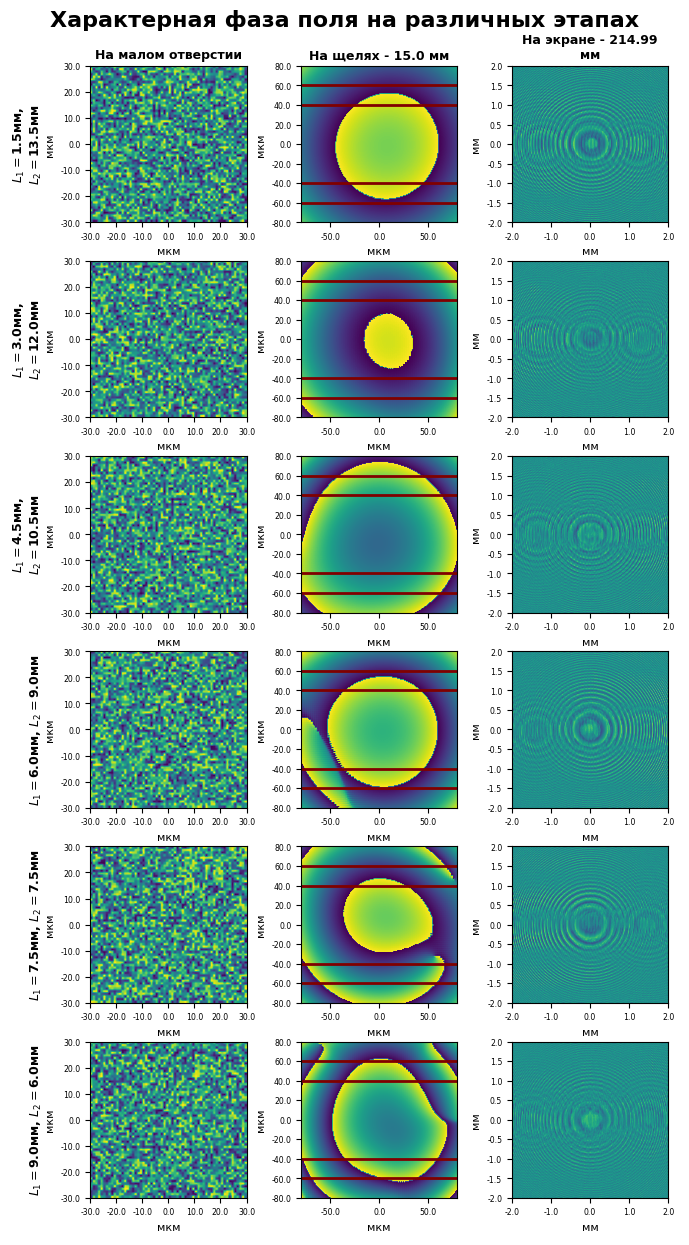

In [13]:
plot = TiledPlot(FigureWidthHeight[0])
plot.FontLibrary = FontLibrary
plot.title("Характерная фаза поля на различных этапах")
plot.description.column.top("На малом отверстии", 0)
plot.description.column.top(f"На щелях - {engineering(distance,'м')}", 1)
plot.description.column.top(f"На экране - {engineering(distance+propagation,'м')}", 2)


for row, (ratio, pin_hole_image, slits_image, screen_image) in enumerate(zip(ratios_sharp, pin_hole_phases, slits_phases, screen_phases)):
    distance_1 = distance * ratio
    distance_2 = distance * (1.0 - ratio)
    plot.description.row.left(f"$L_1=${engineering(distance_1,'м',1,space='')}, $L_2=${engineering(distance_2,'м',1,space='')}", row)
    for col, (image, L) in enumerate(zip([pin_hole_image, slits_image, screen_image], [pin_hole_radius*3, slit_space+slit_width*3, length])):
        N0, N1, L = zoom_to(min(L, length))
        formatter, unit = engineering.separatedformatter(L, 'м')
        axes = plot.axes.add(col,row)
        axes.imshow(image[N0:N1,N0:N1], aspect='auto', extent=[-L/2,+L/2]*2)
        axes.xaxis.set_major_formatter(formatter)
        axes.yaxis.set_major_formatter(formatter)
        plot.graph.label.x(unit)
        plot.graph.label.y(unit)
        if col == 1:
            axes.axhline(-(slit_space+slit_width)/2, color='maroon', linewidth=2.0)
            axes.axhline(+(slit_space+slit_width)/2, color='maroon', linewidth=2.0)
            axes.axhline(-(slit_space-slit_width)/2, color='maroon', linewidth=2.0)
            axes.axhline(+(slit_space-slit_width)/2, color='maroon', linewidth=2.0)
    
plot.show()

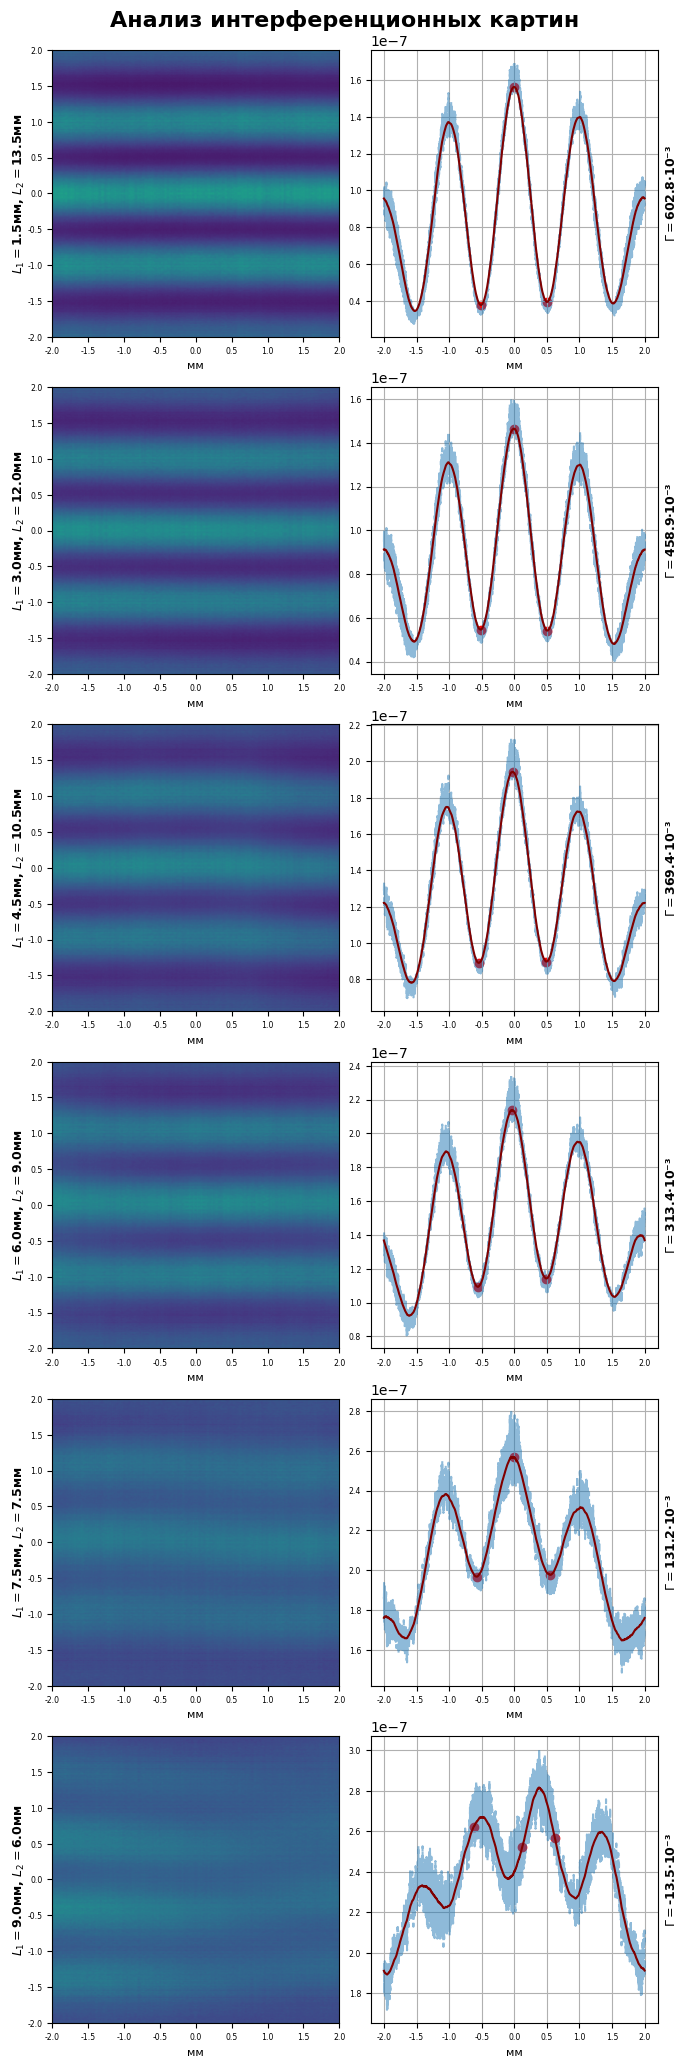

In [14]:
# Отрисовка усреднённыйх интерференционных картин
plot = TiledPlot(FigureWidthHeight[0])
plot.FontLibrary = FontLibrary
plot.title("Анализ интерференционных картин")


for row, (ratio, screen_image) in enumerate(zip(ratios_sharp, screen_intensities)):
    distance_1 = distance * ratio
    distance_2 = distance * (1.0 - ratio)
    plot.description.row.left(f"$L_1=${engineering(distance_1,'м',1,space='')}, $L_2=${engineering(distance_2,'м',1,space='')}", row)

    formatter, unit = engineering.separatedformatter(length, 'м')
    
    axes = plot.axes.add(0,row)
    axes.imshow(screen_image, aspect='auto', extent=[-length/2,+length/2]*2)
    axes.xaxis.set_major_formatter(formatter)
    axes.yaxis.set_major_formatter(formatter)
    plot.graph.label.x(unit)

    with torch.no_grad():
        meaned = screen_image.mean(dim=1)
        furrier = torch.fft.fftshift(torch.fft.fft(meaned))
        window = 0.05
        window = int(N*window)
        window1 = N//2 - window//2
        window2 = window1 + window
        window = torch.zeros(1,1,N)
        window[:,:,window1:window2] = 1.0 / (window2 - window1)
        window = torch.fft.fftshift(torch.fft.fft(window)).abs()
        filtered = torch.fft.ifft(torch.fft.ifftshift(furrier*window)).abs().squeeze()
        # ЭТО НАСТРАИВАЕТСЯ РУКАМИ!!!
        pos0 = 0.0
        pos10 = 0.5E-3
        pos11 = -0.5E-3
        area = 0.25E-3
        # ---------------------------
        pixels = area * N / length
        n0_0 = int((pos0 + length/2) * N / length - pixels/2) 
        n0_1 = int(n0_0 + pixels)
        n10_0 = int((pos10 + length/2) * N / length - pixels/2) 
        n10_1 = int(n10_0 + pixels)
        n11_0 = int((pos11 + length/2) * N / length - pixels/2) 
        n11_1 = int(n11_0 + pixels)
        maximum, maximum_n = torch.max(filtered[n0_0:n0_1],dim=0)
        minimum0, minimum0_n = torch.min(filtered[n10_0:n10_1],dim=0)
        minimum1, minimum1_n = torch.min(filtered[n11_0:n11_1],dim=0)
        minimum = (minimum0 + minimum1)/2
        gamma = (maximum - minimum) / (maximum + minimum)

        points = torch.tensor([n10_0 + minimum0_n, n0_0 + maximum_n, n11_0 + minimum1_n])
        values = torch.tensor([minimum0, maximum, minimum1])
        points = points * length / N - length/2
    
    axes = plot.axes.add(1,row)
    axes.grid(True)
    axes.plot(x_mesh[:,0].cpu(), meaned, alpha=0.5, linestyle='--')
    axes.plot(x_mesh[:,0].cpu(), filtered, color='maroon', alpha=1.0)
    axes.scatter(points, values, c='red', alpha=1.0)
    axes.xaxis.set_major_formatter(formatter)
    plot.graph.label.x(unit)

    plot.description.row.right(f"$\\Gamma=${scientific(gamma.item(),'',1,space='')}", row)

plot.show()